# Day 22: AI-Augmented Chaos Engineering

Use AI to design chaos experiments that target weak spots in your system.

**Goal:**
- Feed system topology and past incident data into an LLM.
- Ask it to propose chaos scenarios (e.g., kill DB node, throttle API).

In [45]:
# Install required libraries
!pip install requests --quiet

In [46]:
# Import libraries
import requests
import json

In [47]:
# Load system topology and incident data dynamically from JSON/YAML files
import json
import yaml

def load_json_or_yaml(filepath):
    if filepath.endswith('.json'):
        with open(filepath, 'r') as f:
            return json.load(f)
    elif filepath.endswith('.yaml') or filepath.endswith('.yml'):
        with open(filepath, 'r') as f:
            return yaml.safe_load(f)
    else:
        raise ValueError("Unsupported file format. Use .json or .yaml")

# Prompt user for file paths or use defaults
import os

system_topology_path = input("Enter path to system topology file (JSON/YAML): ").strip() or "system_topology.json"
past_incidents_path = input("Enter path to past incidents file (JSON/YAML): ").strip() or "past_incidents.json"

if os.path.exists(system_topology_path) and os.path.exists(past_incidents_path):
    system_topology = load_json_or_yaml(system_topology_path)
    past_incidents = load_json_or_yaml(past_incidents_path)
    print("Loaded system topology and past incidents from files.")
else:
    print("File(s) not found. Please provide valid paths to your system topology and incident data files.")
    # Optionally, exit or fall back to hardcoded example
    system_topology = {
        'services': ['web', 'api', 'db', 'cache'],
        'dependencies': {
            'web': ['api'],
            'api': ['db', 'cache'],
            'db': [],
            'cache': []
        },
        'nodes': {
            'web': 2,
            'api': 2,
            'db': 1,
            'cache': 1
        }
    }
    past_incidents = [
        {'service': 'db', 'type': 'outage', 'impact': 'high', 'description': 'Primary DB node failure caused downtime.'},
        {'service': 'api', 'type': 'latency', 'impact': 'medium', 'description': 'API latency spike during cache miss.'},
        {'service': 'web', 'type': 'error', 'impact': 'low', 'description': 'Web service returned 502 due to API timeout.'}
    ]
    print("Using example data.")

File(s) not found. Please provide valid paths to your system topology and incident data files.
Using example data.


In [48]:
import requests
import json

prompt = (
    "You are a chaos engineering expert. Given the following system topology and past incident data, "
    "propose a set of chaos experiments that would target the system's weak spots. "
    "List 3-5 chaos scenarios in markdown table format with columns: Experiment, Target, Action, Expected Outcome.\n\n"
    f"System topology:\n{json.dumps(system_topology, indent=2)}\n\n"
    f"Past incidents:\n{json.dumps(past_incidents, indent=2)}"
)

OLLAMA_URL = "http://localhost:11434/api/generate"
payload = {"model": "llama3", "prompt": prompt, "stream": False}
response = requests.post(OLLAMA_URL, json=payload)
llm_output = response.json().get("response", "")

with open("chaos_experiments.md", "w") as f:
    f.write(llm_output)

In [51]:
import re
import pandas as pd

with open("chaos_experiments.md", "r") as f:
    lines = f.readlines()

# Extract only table rows, skip alignment and header rows with "---"
table_lines = [line for line in lines if "|" in line and not line.strip().startswith("|---")]

cleaned_rows = []
for line in table_lines:
    line = re.sub(r"\*\*(.*?)\*\*", r"\1", line)  # remove bold
    line = line.strip().strip("|")
    cleaned_rows.append([col.strip() for col in line.split("|")])

# Remove rows that are just "---" or empty
filtered_rows = [row for row in cleaned_rows if not all(col == "---" or col == "" for col in row)]

# Remove header row if it contains only "---"
if filtered_rows and all(col == "---" for col in filtered_rows[0]):
    filtered_rows = filtered_rows[1:]

# Remove any row where 'Experiment' is "---"
if filtered_rows and filtered_rows[0][0].lower() == "experiment":
    columns = filtered_rows[0]
    data = [row for row in filtered_rows[1:] if row[0] != "---"]
else:
    columns = filtered_rows[0]
    data = filtered_rows[1:]

df_chaos = pd.DataFrame(data, columns=columns)

# Replace empty or 'None' values in 'Expected Outcome' with a more readable string if desired
df_chaos["Expected Outcome"] = df_chaos["Expected Outcome"].replace(["None", "", "null"], "No outcome provided")

df_chaos.to_csv("chaos_experiments.csv", index=False)
df_chaos.head()

,Experiment,Target,Action,Expected Outcome
0,DB Outage,"""db""",Simulate a temporary DB node failure by termin...,No outcome provided
1,API Cache Miss,"""api""",Inject high-latency responses from cache misse...,None
2,Web API Timeout,"""web"" & ""api""",Simulate an intentional timeout between the we...,None
3,Cache Failover,"""cache""",Simulate a temporary failure of the cache serv...,None


C:\Users\behip\AppData\Local\Temp\ipykernel_19792\4216169805.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(


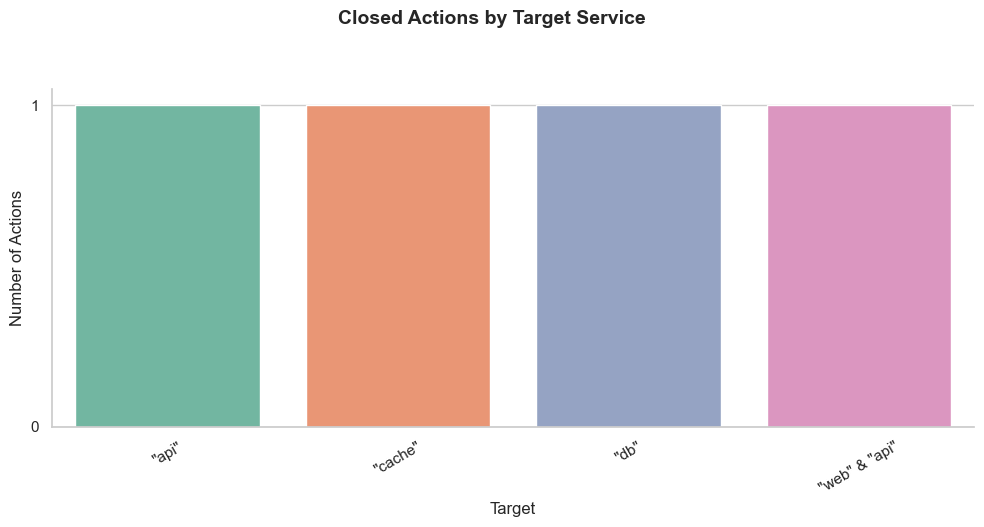

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create the plot
plot = sns.catplot(
    data=df_counts,
    x="Target",
    y="Count",
    kind="bar",
    height=5,
    aspect=2,
    palette="Set2"
)

# Apply styling
plot.fig.suptitle("Closed Actions by Target Service", fontsize=14, fontweight="bold", y=1.05)
plot.set_axis_labels("Target", "Number of Actions")
plot.set_xticklabels(rotation=30)

# Force integer ticks on y-axis
ax = plot.ax
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()